### Load libraries

In [1]:
# systemic libraries
import os 
import sys
import tempfile
import warnings
from datetime import date

# single-cell and data-wrangling 
import scanpy as sc 
import pandas as pd 
import numpy as np 
import numba as nb
import anndata as ad
import leidenalg
import scanpy.external as sce
import harmonypy
import decoupler

# visualization
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns

<i><b> Set the home directory </b></i>

In [2]:
# Define the home_path 
os.environ['HOME_Nikola_scdgomics'] = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics"
home_path = os.getenv("HOME_Nikola_scdgomics")
home_path

'/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics'

<i><b> Set the container image </b></i>

In [3]:
with open("/image_version", "r") as f:
    image_name = f.readline().replace("\n", "")
image_name

'sddcunit/downstream:sc-1.1.0'

### Load the data

In [4]:
# Load the individual datasets to extract sample_id information
#adata = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_normalized.h5ad")

### Data integration

In [5]:
# Define paths
adata_file = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/integration_harmony"
harmony_script_path = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/integration_harmony/integration_script.py"
sbatch_script_path = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/integration_harmony/run_integration.job"

In [6]:
# Write the integration script 
integration_script = f"""
import os 
import sys
import tempfile
import warnings
from datetime import date

# single-cell and data-wrangling 
import scanpy as sc 
import pandas as pd 
import numpy as np 
import numba as nb
import anndata as ad
import leidenalg
import scanpy.external as sce
import harmonypy

# Load the data
adata_name = "/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_normalized.h5ad"
adata = sc.read_h5ad(adata_name)

# Select the layer
adata.X = adata.layers['log_normalized_scaled_counts'].copy()

# Calculate the PCA 
sc.tl.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack', random_state = 80)

# Run harmony
sce.pp.harmony_integrate(adata, key = 'dataset_of_origin', adjusted_basis='X_pca_harmony',
                         max_iter_harmony = 30)

# Save the data
adata.write_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_integrated_harmony.h5ad")

"""
with open(harmony_script_path, "w") as f:
    f.write(integration_script)

In [7]:
# Write the bash script
sbatch_script = f"""#!/bin/bash
#SBATCH --time=24:00:00
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --gres=gpu:1
#SBATCH --partition=gpuq
#SBATCH --job-name=integration
#SBATCH --mem=64GB
#SBATCH --mail-type=END
#SBATCH --output=%x_%j.log

export SINGULARITY_CACHEDIR=/group/kalebic/Nikola/1_single_cell_final/Nikola_final/scmorpho/.singularity/
export SINGULARITY_TMPDIR=$TMPDIR

module load cuda11.1/toolkit/11.1.1
module load singularity
singularity exec --nv -H {home_path} \\
                 docker://{image_name} \\
                 python3 {os.path.abspath(harmony_script_path)}

"""

with open(sbatch_script_path, "w") as f:   
    f.write(sbatch_script)

### Neighboring

In [8]:
# Load the integrated data
adata = sc.read_h5ad("/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_integrated_harmony.h5ad")

In [9]:
# Compute the kNN graph
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_pcs=30, n_neighbors=80, random_state = 111)

2025-04-11 15:58:50.454859: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 15:58:50.458057: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 15:58:50.492733: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-11 15:58:50.492784: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-11 15:58:50.492809: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [10]:
# Compute the UMAP
sc.tl.umap(adata, random_state = 111)

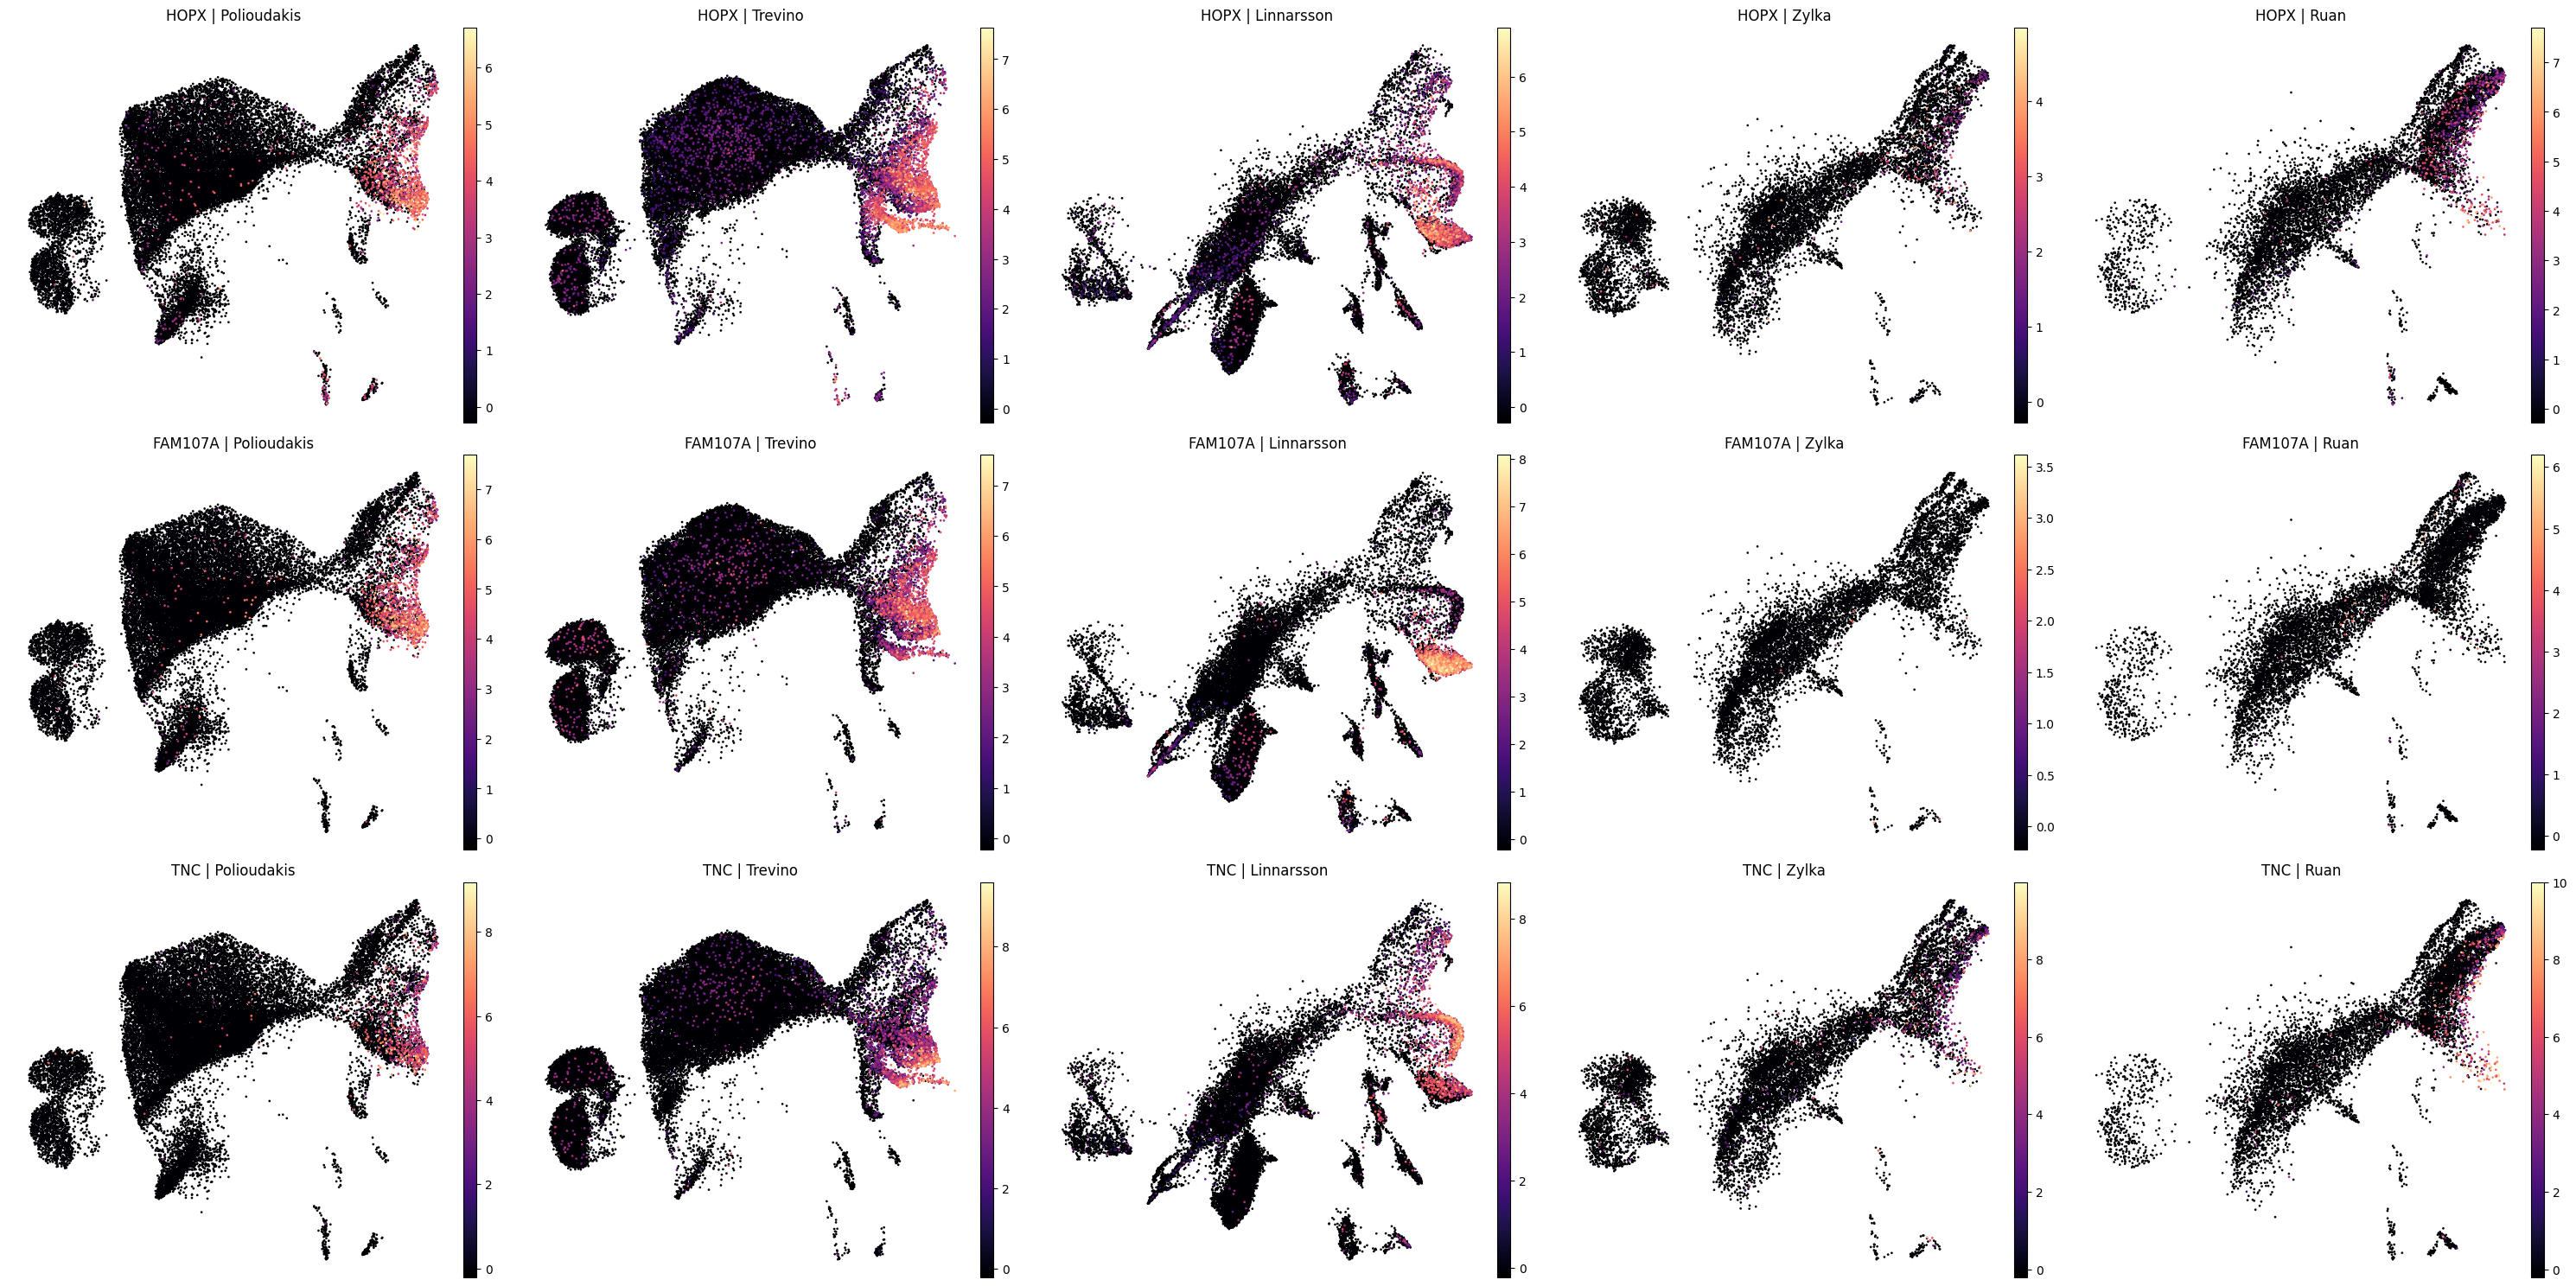

In [11]:
# List genes of interest
genes = ['HOPX', 'FAM107A', 'TNC']

# Define the subplots
fig, axes = plt.subplots(len(genes), len(adata.obs['dataset_of_origin'].unique()), figsize = (6*len(adata.obs['dataset_of_origin'].unique()), 5*len(genes)))
axes = axes.flatten()

# Plot gene expression across datasets
sp_index = 0
for r_idx, gene in enumerate(genes):
    for d_idx, dataset in enumerate(adata.obs['dataset_of_origin'].unique()):
        ax = axes[sp_index]
        sc.pl.umap(
            adata[adata.obs['dataset_of_origin'] == dataset], 
            color = gene, 
            ax = ax, 
            show = False, 
            size = 15, 
            frameon = False, 
            legend_loc = 'on_data', 
            legend_fontsize = 10, 
            cmap = 'magma'
        )
        ax.set_title(f"{gene} | {dataset}")
        sp_index += 1

plt.tight_layout()
plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/UMAP_hNcx_mDG_mNcx_integrated_bRG_marker_expression.png', 
            dpi = 300, bbox_inches = 'tight')
plt.show() 

### Clustering

In [12]:
# Compute the leiden clustering at low-resolution (per species)
sc.tl.leiden(adata, key_added="X_leiden_harmony", resolution=0.40, random_state = 111)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


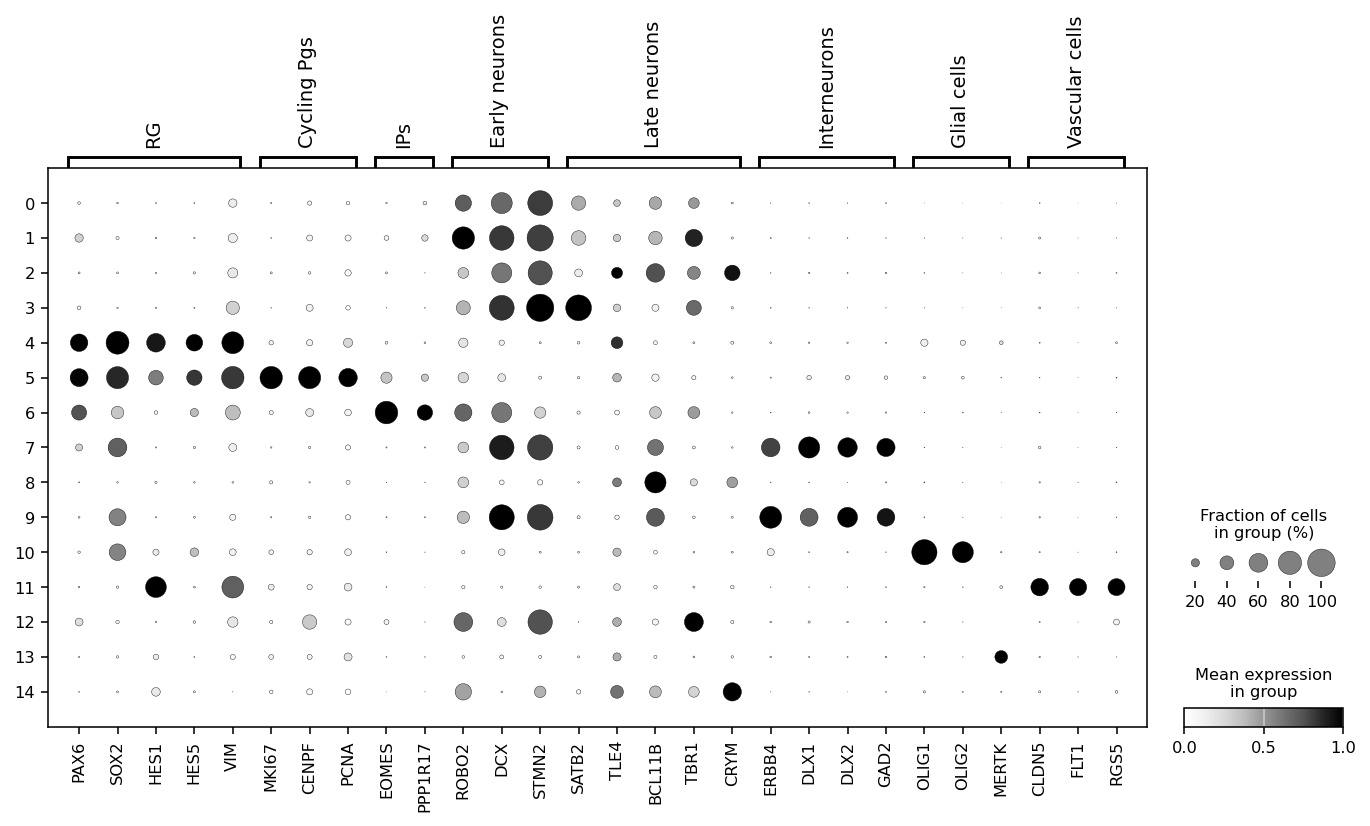

In [13]:
# Plot the expression of marker genes across clusters
sc.set_figure_params(dpi = 70, dpi_save = 300, fontsize = 10)
markers = {'RG': ['PAX6', 'SOX2', 'HES1', 'HES5', 'VIM'], 
           'Cycling Pgs': ['MKI67', 'CENPF', 'PCNA'],
           'IPs' : ['EOMES', 'PPP1R17'], 
           'Early neurons' : ['ROBO2', 'DCX', 'STMN2'],
           'Late neurons' : ['SATB2','TLE4', 'BCL11B', 'TBR1', 'CRYM'],
           'Interneurons' : ['ERBB4', 'DLX1', 'DLX2', 'GAD2'],
           'Glial cells' : ['OLIG1', 'OLIG2', 'MERTK'],
           'Vascular cells': ['CLDN5', 'FLT1', 'RGS5'], 
          }

sc.pl.dotplot(adata, markers, groupby ='X_leiden_harmony', mean_only_expressed = False, 
              show = True, standard_scale = 'var', cmap = 'Greys')

#plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/Dotplot_integrated_leiden_clusters.svg', dpi = 300, bbox_inches = 'tight')
plt.show()

In [14]:
# Rename the clusters
new_cluster_names = ['N1', 'N2', 'N3', 'N4', 'G1 RG', 'G2M-S Pgs', 'G1 IPs', 'IN1', 'N5', 'IN2', 'Glia', 
                     'Endothelial', 'N6', 'Microglia', 'N7']

adata.rename_categories('X_leiden_harmony', new_cluster_names)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


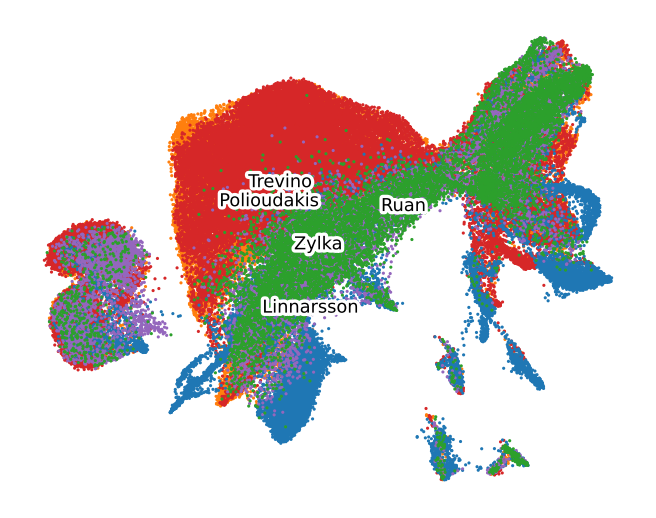

In [15]:
# Plot the UMAP
sc.set_figure_params(figsize=(5, 4))
ax = sc.pl.umap(adata, color=["dataset_of_origin"],frameon=False, show = False, legend_fontsize=8, size =8,
                legend_loc = 'on data', legend_fontweight=3, ncols = 1, legend_fontoutline = 3, title = '')

ax.set_xlabel('UMAP1',fontsize=10)
ax.set_ylabel('UMAP2',fontsize=10)

plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/UMAP_integrated_dataset_of_origin.png', dpi = 300, bbox_inches = 'tight')
plt.show()

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


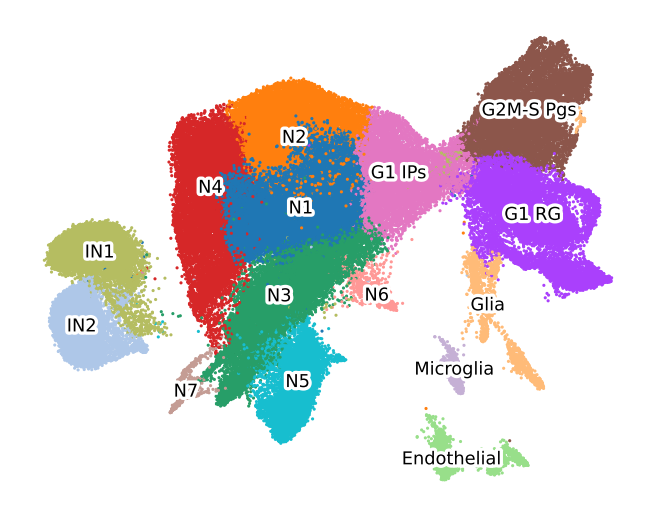

In [16]:
# Plot the UMAP
sc.set_figure_params(figsize=(5, 4))
ax = sc.pl.umap(adata, color=["X_leiden_harmony"],frameon=False, show = False, legend_fontsize=8, size =8,
                legend_loc = 'on data', legend_fontweight=3, ncols = 1, legend_fontoutline = 3, title = '')

ax.set_xlabel('UMAP1',fontsize=10)
ax.set_ylabel('UMAP2',fontsize=10)

plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/UMAP_integrated_clusters.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [17]:
# Define the cluster composition per species
#cross_plt = pd.crosstab(adata.obs['dataset_of_origin'], adata.obs['X_leiden_harmony'], normalize='columns')*100
#
# Re-order clusters
#ordered_clusters = ['G1 RG','G1 IPs','G2M-S Pgs', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7',
#                    'Glia', 'Endothelial', 'Microglia', 'IN1', 'IN2']
#
# Plot the stacked-bar graph
#cross_plt_reindexed = cross_plt[ordered_clusters]
#
# Re-order datasets
#ordered_dataset = ['Zylka', 'Ruan', 'Linnarsson', 'Polioudakis', 'Trevino']
#cross_plt_reindexed = cross_plt_reindexed.reindex(ordered_dataset)
#
# Plot
#fig, ax = plt.subplots(figsize=(7, 4))
#ax = cross_plt_reindexed.T.plot(kind='bar', stacked=True, colormap='tab20b', width=0.9, ax = ax)
#ax.legend(title="", bbox_to_anchor=(1.11, 1.01), loc='upper center', fontsize = 10)
#ax.tick_params(axis='x', labelrotation=90)
#ax.set(xlabel=None)
#ax.set_title('', loc = 'center', fontsize = 8)
#ax.grid(False)
#ax.set_ylabel("% of cells per dataset", labelpad=12)
#ax.set_xticklabels(['Zylka', 'Ruan', 'Linnarsson', 'Polioudakis', 'Trevino'], fontsize = 12, rotation = 0)
#ax.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize = 10, rotation = 0)
#
#for rec in ax.patches:
#    height = rec.get_height()
#    if height > 3:
#        ax.text(rec.get_x() + rec.get_width() / 2, 
#                rec.get_y() + height / 5.5,
#                "{:.1f}%".format(height),
#                ha='center', 
#                va='bottom', 
#                fontsize = 7)
#        
#plt.savefig('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/plots/clustering/Cluster_distribution_per_species.png', dpi = 300, bbox_inches = 'tight')
#plt.show()

### Save the data

In [18]:
# Save the anndata
adata.write_h5ad('/group/kalebic/Nikola/1_single_cell_final/Nikola_final/final/scdgomics/data_versions/Adata_clustered.h5ad')